# Infoscent

In this notebook, I simulate user exploration of GUIs through semantic analysis of their Information Architecture. 

This project is motivated by previous research (Fu & Pirolli, 2007; Blackmon, Kitajima, & Polson, 2005) on predicting user exploration of websites. 

Users are assumed to navigate a GUI by iteratively clicking the label of each state that is the most semantically similar to a goal (infoscent).

Previous infoscent models were based on Latent Sematic Indexing (LSI) language models. 

This project simulates and compares a user's semantic exploration of an on-board automative GUI using 3 different language models:
- Latent Sematic Indexing (LSI)
- Latent Dirichlet Analysis (LDA)
- Word Vector Representation (Word2Vec)

Each model is trained with plain English and lemmatized tokenizations.

In [57]:
import pickle
import operator

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) 

# Natural Language Processing modules
from gensim import corpora, models, similarities, utils
from pattern.en import tag, parse
from nltk.corpus import wordnet as wn, stopwords
from nltk.tokenize import RegexpTokenizer

# Data/Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics and Machine-learning modules
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import datasets, linear_model

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Materials

###GUI IA, target features, and goal descriptions

The GUI for this project follows the IA of an on-board computer.

In [58]:
# GUI information architectures (IAs) represented as a nested dictionary
gui3 = {"car":{"air conditioning" : "air conditioning",
               "driving assistance" : {"gps": "gps", 
                                       "lane change alert" : "lane change alert", 
                                      "cruise control": {"activate cruise control":"activate cruise control", 
                                                         "turn off cruise control":"turn off cruise control"}, 
                                      "anti theft notification" :"anti theft notification"}}, 
        "phone": {"dial number": "dial number","contact list": "contact list", 
                  "check voice mail messages":"check voice mail messages"}, 
        "play radio": "play radio"}

Goal descriptions are plain English descriptions of certain task, e.g. "find my friend's contact number."
The target feature is the feature in the interface that accomplishes this goal.
Each task is classified as "basic" or "technical".
Each task in the following test_set is formatted as:

('target feature', 'goal description', 'classification')

In [59]:
# List of test materials (target_features, goals, level)
test_set1 = [('air conditioning', 'increase temperature', 'basic'),
 ('activate cruise control', 'limit my speed', 'technical'),
 ('turn off cruise control', 'disable speed alert', 'technical'),
 ('anti theft notification', 'alert that my car stolen', 'technical'),
 ('lane change alert', 'disable car passing support system', 'technical'),
 ('gps', 'get directions office', 'technical'),
 ('play radio', 'listen beatles last album', 'basic'),
 ('contact list', 'retrieve my friend mailing address', 'basic'),
 ('dial number', 'call', 'basic'),
 ('check voice mail messages', 'go through recent phone messages', 'basic')]

Familiarity of a target feature is calculated by counting the number of synsets associated with each word in the feature. Total number is counted and stored in a list.

In [60]:
#Retrieve basic polysemy proxy from nltk's interface for wordnet

wn_fam = []

for test in test_set1:
    tokenizer = RegexpTokenizer(r'\w+')
    toketxt = tokenizer.tokenize(test[0])
    s = set(stopwords.words('english'))
    filt_wrd = [w for w in toketxt if not w in s]
    w_count = len(filt_wrd)
    g_polys = 0

    for word in filt_wrd:
        w_polys = len(wn.synsets(word))
        g_polys += w_polys

    av_polys = float(g_polys)/float(w_count)
    wn_fam.append(round(av_polys, 2))

print sorted(wn_fam)

[1.0, 2.0, 9.0, 9.67, 9.67, 10.5, 11.5, 15.75, 20.67, 28.5]


In [61]:
wn_fam_NN = []

for test in test_set1: 
    filt_wrd = []
    g = test[0]
    for w, pos in tag(g): 
        if pos == "NN":
            filt_wrd.append(w)

    w_count = len(filt_wrd)
    g_polys = 0

    for word in filt_wrd:
        w_polys = len(wn.synsets(word))
        g_polys += w_polys
        
    av_polys = float(g_polys)/float(w_count)
    wn_fam_NN.append(round(av_polys, 2))

print sorted(wn_fam_NN) 

[1.0, 2.0, 7.0, 10.5, 11.0, 12.0, 12.0, 17.0, 19.33, 28.5]


['target_feat' 'goal' 'counts' 'familiarity' 'wn_familiarity'
 'wn_familiarity_NN' 'model' 'prepping']


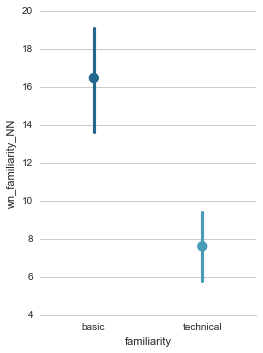

In [27]:
sns.set(style="whitegrid")
print df_gui3.columns.values
g = sns.factorplot(x="familiarity", y="wn_familiarity_NN", data=df_gui3,
                   palette="YlGnBu_d", size=5, aspect=.75)
g.despine(left=True)

## Similarity matrix for Goals and Target features

Word2vec n_similarity function is used to calculate a similarity score between each goal description and target feature.
The entire matrix is stored in a Pandas dataframe.

In [79]:
goal_index = []
for goal in test_set1:
    goal_index.append(goal[1])

sim_heatmap = pd.DataFrame(index=goal_index)

for i, feat in enumerate(test_set1):
    sim_features = []
    for j, goal in enumerate(test_set1):
        sim_features.append(tok_w2v.n_similarity(feat[0].split(), goal[1].split()) )
    sim_heatmap[feat[0]] = sim_features
sim_heatmap.head()

,air conditioning,activate cruise control,turn off cruise control,anti theft notification,lane change alert,gps,play radio,contact list,dial number,check voice mail messages
increase temperature,0.343821,0.248899,0.203634,0.116112,0.406705,0.198475,-0.071758,0.156829,0.149088,0.079286
limit my speed,0.246538,0.225209,0.412864,0.149728,0.315220,0.251474,0.154433,0.155063,0.277318,0.251444
disable speed alert,0.387455,0.449580,0.388973,0.352458,0.566966,0.413387,0.089045,0.073983,0.200452,0.378668
alert that my car stolen,0.213606,0.348870,0.432120,0.381996,0.565726,0.212202,0.196193,0.247469,0.209524,0.362186
disable car passing support system,0.340408,0.549172,0.493006,0.423879,0.395586,0.468855,0.187575,0.257031,0.347098,0.442792


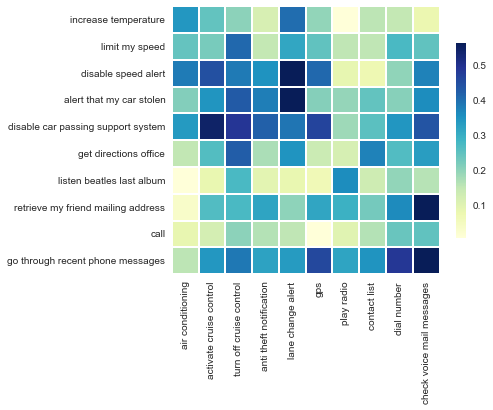

In [80]:
# Plot similarity matrix as heatmap
f, ax = plt.subplots(figsize=(6, 7))

# Draw the heatmap 
sns.heatmap(sim_heatmap,cmap="YlGnBu",
            robust=True,#annot=True,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

### Corpus

Models on the Simple English Wikipedia corpus.
File name: [simplewiki-20150901-pages-articles.xml.bz2](http://dumps.wikimedia.org/simplewiki/20150901/) (106.3 MB)

Other interesting alternatives include:
- The [UMBC WebBase corpus](http://ebiquity.umbc.edu/blogger/2013/05/01/umbc-webbase-corpus-of-3b-english-words/)
- The college-level [TASA corpus](http://lsa.colorado.edu/spaces.html)


GRRRR
### LSI and LDA Models

#### Plain versions
Generation of dictionaries and tf-idf representations are built from the [gensim.scripts.make_wiki](http://pydoc.net/Python/gensim/0.9.1/gensim.scripts.make_wiki/) script. Sparse representation of the Simple English Wikipedia corpus can be obtained by running the script: 

    python -m gensim.scripts.make_wikicorpus ./enwiki-latest-pages-articles.xml.bz2 ./results/wiki_en

Input file is a bz2-compressed dump of Wikipedia articles in XML format. Three output files are created:

- wiki_en_wordids.txt (mapping between words and their integer IDs)
- wiki_en_bow.mm: bag-of-words (word count) representation, in Matrix Market format
- wiki_en_tfidf.mm: TF-IDF representation

Vocabulary size is set to 100,000 most frequent words using plain alphabetic tokenizer. 

#### Lemmatized versions

To tokenize with "fancy" lemmatization, we use the Pattern package (see https://github.com/clips/pattern).
Lemmatized versions of the same three files can be created by running this [script](http://pydoc.net/Python/gensim/0.9.1/gensim.scripts.make_wiki_lemma/):

    python -m gensim.scripts.make_wiki_lemma ./enwiki-latest-pages-articles.xml.bz2 ./results_lem/wiki_en

In [5]:
# Load tf-idf representation and dictionary mapping for tokenized corpus
wiki = corpora.MmCorpus('latent_tok_tfidf.mm')
mon_dico = corpora.Dictionary.load_from_text('latent_tok_wordids.txt')

# Lemmatized tf-idf representation and dictionary
wiki_lem = corpora.MmCorpus('latent_lem_tfidf.mm')
mon_dico_lem = corpora.Dictionary.load_from_text('latent_lem_wordids.txt')

print "Tokenized corpus:", wiki
print mon_dico, '\n'
print "Lemmatized corpus:", wiki_lem
print mon_dico_lem

Tokenized corpus: MmCorpus(73898 documents, 29597 features, 6418219 non-zero entries)
Dictionary(29597 unique tokens: [u'fawn', u'schlegel', u'sonja', u'woods', u'spiders']...) 

Lemmatized corpus: MmCorpus(59245 documents, 26640 features, 5275674 non-zero entries)
Dictionary(26640 unique tokens: [u'adjust/VB', u'meteor/NN', u'certificate/NN', u'alcatraz/NN', u'removal/NN']...)


### Train LSI and LDA models

If either model has already been trained and pickled, the training in this cell will be skipped. 

**Note: this cell does NOT load the pickle files, but only checks if they exist!**

In [62]:
try:
    pickle.load(open('pickle_lsi.p', 'rb'))
except:
    print "Pickle not found, training new LSI model... \n"
    lsi = models.lsimodel.LsiModel(corpus=wiki, id2word=mon_dico, num_topics=450)
    print 'Top LSI topics:', lsi.print_topics(5), '\n'
    pickle.dump(lsi, open('pickle_lsi.p', 'wb'))

try:
    pickle.load(open ('pickle_lda.p', 'rb'))
except:
    print "Pickle not found, training new LDA model... \n"
    lda = models.ldamodel.LdaModel(corpus=wiki, id2word=mon_dico, 
                                   num_topics=450, update_every=1, chunksize=2000, passes=1)
    print 'Top LDA topics:', lda.print_topics(5), '\n'
    pickle.dump(lda, open('pickle_lda.p', 'wb'))

### Train lemmatized LSI and LDA models

If either model has already been trained and pickled, the training in this cell will be skipped. 

**Note: this cell does NOT load the pickle files, but only checks if they exist!**

In [7]:
try:
    pickle.load(open('pickle_lsi_lem.p', 'rb'))
except:
    print "Pickle not found, training new lemmatized LSI model... \n"
    lsi_lem = models.lsimodel.LsiModel(corpus=wiki_lem, id2word=mon_dico_lem, num_topics=450)
    print 'Top LSI topics:', lsi_lem.print_topics(5), '\n'
    pickle.dump(lsi_lem, open('pickle_lsi_lem.p', 'wb'))

try:
    pickle.load(open('pickle_lda_lem.p', 'rb'))
except:
    print "Pickle not found, training new lemmatized LDA model... \n"
    lda_lem = models.ldamodel.LdaModel(corpus=wiki_lem, id2word=mon_dico_lem, 
                                       num_topics=450, update_every=1, chunksize=2000, passes=1)
    print 'Top LDA topics:', lda_lem.print_topics(5), '\n'
    pickle.dump(lda_lem, open('pickle_lda_lem.p', 'wb'))

## Word2vec model

We use the word2vec included in the Gensim package.
The following model uses plain English tokenization.

**Note: this cell can be skipped if the file 'wiki_w2v_tokens.txt' already exists!**

In [8]:
# Simple English Wikipedia corpus
wiki_w2v = 'simplewiki-20150901-pages-articles.xml.bz2' 

# Tokenize the corpus
wiki_w2v_tok = corpora.WikiCorpus(wiki_w2v, lemmatize=False, dictionary={})

# Process each article, each line in output doc is BOW article
outfile = 'wiki_w2v_tokens.txt'
output = open(outfile, 'w')
space = " "
i = 0
for text in wiki_w2v_tok.get_texts():
    output.write(space.join(text) + "\n")
    i = i + 1
output.close()
print "DONE"
print "Saved " + str(i) + " articles."

DONE
Saved 73898 articles.


### Lemmatized version

This model uses lemmatization provided by the Pattern package.

**Note: this cell can be skipped if the file 'wiki_w2v_lemmes.txt' already exists!**

In [9]:
#Corpus of lemmas
wiki_w2v_lem = corpora.WikiCorpus(wiki_w2v, lemmatize=True, dictionary={})

#create an output file to get the corpus into a list tokenized (preprocessed) articles (every line being a bow per article)
outfile = 'wiki_w2v_lemmes.txt'
output = open(outfile, 'w')
space = " "
i = 0
for text in wiki_w2v_lem.get_texts():
    output.write(space.join(text) + "\n")
    i = i + 1
output.close()
print "DONE"
print "Saved " + str(i) + " articles."

DONE
Saved 59245 articles.


## Train word2vec models

The following cell performs the following steps:
- dictionary is created from tokens
- top 100K words are filtered
- word2vec model is trained

In [139]:
# Create dictionary of tokens and filter the corpus
wiki_w2v_tok = models.word2vec.LineSentence('wiki_w2v_tokens.txt')
id2word = corpora.Dictionary(wiki_w2v_tok)
id2word.filter_extremes(keep_n=100000)                 # Restrict dico to 100k most common words.
word2id = dict((word, id) for id, word in id2word.iteritems()) 

# Functions to filter the corpus
filter_text = lambda text: [word for word in text if word in word2id]  # Filter all wiki doc to contain only those 100k words.
filtered_wiki_tok = lambda: (filter_text(text) for text in wiki_w2v_tok)  # generator

# Train model
model_w2v_tok = models.word2vec.Word2Vec (size=200, window=10, sample=0.0001, workers=4)
model_w2v_tok.build_vocab(filtered_wiki_tok())
model_w2v_tok.train(filtered_wiki_tok())

# Pickle model to disk
model_w2v_tok.save('word2vec_tok.model')

# Store the learned weights, in a format the original C tool understands
model_w2v_tok.save_word2vec_format('word2vec_tok.model.bin', binary=True)

<function <lambda> at 0x12be6a488>


### Train lemmatized version

Previous cell is repeated for lemmatized version of word2vec model.

In [141]:
#Repeat above cell on lemmatized corpus
wiki_w2v_lem = models.word2vec.LineSentence('wiki_w2v_lemmes.txt')
id2word = corpora.Dictionary(wiki_w2v_lem)
id2word.filter_extremes(keep_n=100000)              # Restrict dico to 100k most common words.
word2id = dict((word, id) for id, word in id2word.iteritems()) 

filter_text = lambda text: [word for word in text if word in word2id]
filtered_wiki_w2v_lem = lambda: (filter_text(text) for text in wiki_w2v_lem)  # generator
print filtered_wiki_w2v_lem

# Train lemmatized model
model_w2v_lem = models.word2vec.Word2Vec (size=200, window=10, sample=0.0001, workers=4)
model_w2v_lem.build_vocab(filtered_wiki_w2v_lem())
model_w2v_lem.train(filtered_wiki_w2v_lem())

# Pickle entire model to disk
model_w2v_lem.save('word2vec_lem.model')

# Store weights
model_w2v_lem.save_word2vec_format('word2vec_lem.model.bin', binary=True)

<function <lambda> at 0x12a9aacf8>


# Load trained models

In [63]:
# Load model pickles
tok_w2v = models.word2vec.Word2Vec.load("word2vec_tok.model")
lem_w2v = models.word2vec.Word2Vec.load("word2vec_lem.model")
tok_lsi = pickle.load (open ('pickle_lsi.p', 'rb'))
tok_lda = pickle.load (open ('pickle_lda.p', 'rb'))
lem_lsi = pickle.load (open ('pickle_lsi_lem.p', 'rb'))
lem_lda = pickle.load (open ('pickle_lda_lem.p', 'rb'))

# Semantic "sniffing" algorithm

The infoscent method is now applid to the GUI.
The following function takes any state of a GUI, calculates the similarity of each feature in that state with a goal, and returns the features as a list sorted by similarity.


In [64]:
# Needs to know the model type (w2v, w2v_lem, latent, latent_lem)
def sim_sort(state, model, goal, model_type):
    sorted_sims = []
    similaritiz = {}
    goal_v = []
    
    # Word2Vec models
    if (model_type == "w2v") or (model_type == "w2v_lem"):
        
        goal_v = goal.lower().split()
        if model_type == "w2v_lem":
            goal_v = utils.lemmatize(goal)

        for label in state.keys():
            k = label.split()
            if model_type == "w2v_lem":
                k = utils.lemmatize(label)
            sim = model.n_similarity(k, goal_v)
            similaritiz[label]=sim          #adding the similarity scores for any label

    # LSI/LDA models
    elif (model_type == "latent") or (model_type == "latent_lem"):
        
        goal_split = goal.lower().split()
        goal_bow = mon_dico.doc2bow(goal_split)
        if model_type == "latent_lem":
            goal_bow = mon_dico_lem.doc2bow(utils.lemmatize(goal))
        goal_v = model[goal_bow]
        
        ar = []
        for label in state.keys():
            k = label.split()
            if model_type == "latent_lem":
                k = utils.lemmatize(label)
            ar.append(k)

        state2index = [mon_dico.doc2bow(txt) for txt in ar]
        if model_type == "latent_lem":
            state2index = [mon_dico_lem.doc2bow(txt) for txt in ar]
        index = similarities.MatrixSimilarity(model[state2index], num_features=29000)
        indexed_scores = list(index[goal_v])
        
        for index, score in enumerate(indexed_scores):       #this could be replaced by zip()
            label = state.keys()[index]
            similaritiz[label] = score
        
    sorted_sims = sorted(similaritiz.items(), key=operator.itemgetter(1), reverse = True) 
    #print sorted_sims
    return sorted_sims                              #returns a list of tuples i.e [(,), (,)]


# Check output
print sim_sort(gui3, tok_w2v, 'call your parents', 'w2v'), "\n"
print sim_sort(gui3, lem_lsi, 'call your parents', 'latent_lem'), "\n"
print sim_sort(gui3, tok_lsi, 'call your parents', 'latent'), "\n"

[('phone', 0.31809471697231229), ('play radio', 0.1796213105050215), ('car', 0.15134431360520267)] 

[('play radio', 0.027771166), ('car', -0.0083550652), ('phone', -0.078603856)] 

[('phone', 0.2054445), ('play radio', -4.966557e-05), ('car', -0.017856039)] 



This function goes recursively down the GUI, comparing semantic similarity of features in each state with the goal description and following the most familiar down the Information Architecture.

In [65]:
def intermediate_sniffer_metrics(gui, model, goal, target_feat, model_type, global_count = 0):
    
    state = sim_sort(gui, model, goal, model_type)    #returned content must be assigned to a variable
    found_goal = False
    #print state
    for label, score in state:
        global_count += 1
        
        if type(gui[label]) is dict:
            found_goal, g_cnt = intermediate_sniffer_metrics(gui[label], model, goal, target_feat, model_type)
            global_count += g_cnt
            if found_goal:
                return True, global_count
    
        elif gui[label] == target_feat:
            return True, global_count

    return False, global_count

#intermediate_sniffer_metrics(gui3, tok, 'cruise control', 'turn off cruise control', 'w2v'), '\n'

## Comparison of model performance

For any goal, this function computes the total number of steps required to "find" the correct target feature. Results are stored for every model type.

In [66]:
def auto_test(test_set, model, model_type):
    test_metrics =[]
    goal_l = []
    target_l=[]
    fam = []
    for a, b, c in test_set:
        goal_l.append(a)
        target_l.append(b)
        fam.append(c)
        result = intermediate_sniffer_metrics(gui3, model, b, a , model_type)
        test_metrics.append(result[1])
    return zip(goal_l, target_l,test_metrics, fam, wn_fam, wn_fam_NN)
    
tok_w2v_test = auto_test(test_set1, tok_w2v, 'w2v')
lem_w2v_test = auto_test(test_set1, lem_w2v, 'w2v_lem')
tok_lsi_test = auto_test(test_set1, tok_lsi, 'latent')
tok_lda_test = auto_test(test_set1, tok_lda, 'latent')
lem_lsi_test = auto_test(test_set1, lem_lsi, 'latent_lem')
lem_lda_test = auto_test(test_set1, lem_lda, 'latent_lem')

Create Pandas dataframes for each model.
Prepare columns for visualizations and model comparison, then concatenate all models into a single dataframe.

In [72]:
df_tok_w2v = pd.DataFrame(tok_w2v_test)
df_tok_w2v['model']='word2vec'
df_tok_w2v['prepping']='tokens'

df_lem_w2v = pd.DataFrame(lem_w2v_test)
df_lem_w2v['model']='word2vec'
df_lem_w2v['prepping']='lemmas'

df_tok_lsi = pd.DataFrame(tok_lsi_test)
df_tok_lsi['model']='lsi'
df_tok_lsi['prepping']='tokens'

df_tok_lda = pd.DataFrame(tok_lda_test)
df_tok_lda['model']='lda'
df_tok_lda['prepping']='tokens'

df_lem_lsi = pd.DataFrame(lem_lsi_test)
df_lem_lsi['model']='lsi'
df_lem_lsi['prepping']='lemmas'

df_lem_lda = pd.DataFrame(lem_lda_test)
df_lem_lda['model']='lda'
df_lem_lda['prepping']='lemmas'

frames = [df_tok_w2v, df_lem_w2v, df_tok_lsi, df_tok_lda, df_lem_lsi, df_lem_lda]
df_gui3=pd.concat(frames)
df_gui3.columns = ['target_feat','goal',  'counts','familiarity','wn_familiarity','wn_familiarity_NN','model', 'prepping']

df_gui3.head(5)

,target_feat,goal,counts,familiarity,wn_familiarity,wn_familiarity_NN,model,prepping
0,air conditioning,increase temperature,2,basic,10.50,10.5,word2vec,tokens
1,activate cruise control,limit my speed,7,technical,9.67,12.0,word2vec,tokens
2,turn off cruise control,disable speed alert,9,technical,20.67,12.0,word2vec,tokens
3,anti theft notification,alert that my car stolen,4,technical,2.00,2.0,word2vec,tokens
4,lane change alert,disable car passing support system,8,technical,9.67,11.0,word2vec,tokens


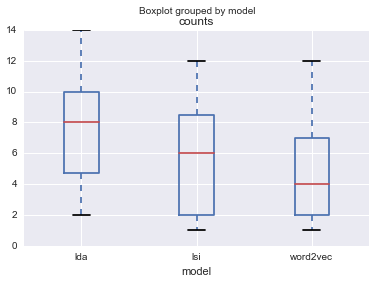

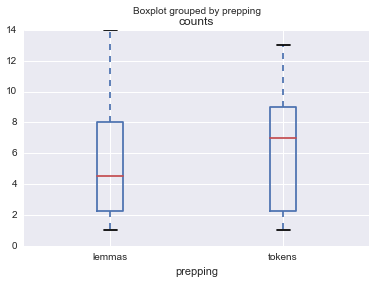

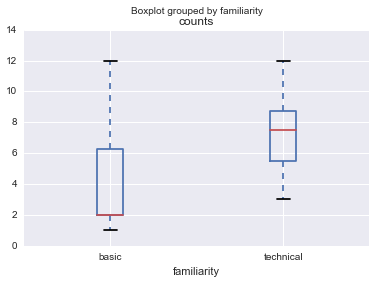

In [73]:
df_gui3.boxplot(column = 'counts', by = 'model')
df_gui3.boxplot(column = 'counts', by = 'prepping')
df_gui3.boxplot(column = 'counts', by = 'familiarity')

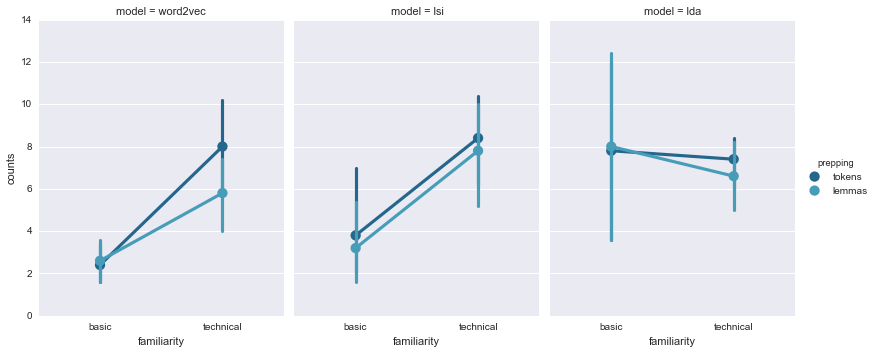

In [74]:
e = sns.factorplot(x="familiarity", y="counts", col = 'model', hue="prepping",data=df_gui3,
                   palette="YlGnBu_d", size=5, aspect=.75)
e.despine(left=True)

In [75]:
print df_gui3.columns

anova_1 = ols('counts ~ C(model, Sum)*C(prepping, Sum)*C(familiarity, Sum)',
               data=df_gui3).fit()
table = sm.stats.anova_lm(anova_1, typ=2) # Type 2 ANOVA DataFrame
print table

Index([u'target_feat', u'goal', u'counts', u'familiarity', u'wn_familiarity',
       u'wn_familiarity_NN', u'model', u'prepping'],
      dtype='object')
                                                        sum_sq  df          F  \
C(model, Sum)                                        76.633333   2   3.863866   
C(prepping, Sum)                                      6.016667   1   0.606723   
C(familiarity, Sum)                                 109.350000   1  11.026891   
C(model, Sum):C(prepping, Sum)                        1.233333   2   0.062185   
C(model, Sum):C(familiarity, Sum)                    97.300000   2   4.905882   
C(prepping, Sum):C(familiarity, Sum)                  4.816667   1   0.485714   
C(model, Sum):C(prepping, Sum):C(familiarity, Sum)    3.633333   2   0.183193   
Residual                                            476.000000  48        NaN   

                                                      PR(>F)  
C(model, Sum)                                       0.

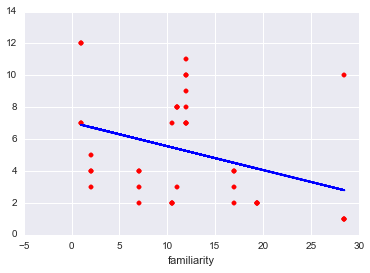

Coefficients: -0.149
Mean residual sum of squares: 9.5
Variance of Y explained by X: 0.123


In [85]:
selecta = df_gui3[df_gui3['model'] != 'lda']

X = selecta['wn_familiarity_NN']
Y = selecta['counts']

regr = linear_model.LinearRegression()
regr.fit (X[:,np.newaxis], Y)

plt.xlabel('familiarity')
plt.scatter(X, Y, color='red')
plt.plot(X, regr.predict(X[:,np.newaxis]), color='blue')
plt.show()

# The coefficients
print 'Coefficients: %.3f' % regr.coef_[0]
# The mean square error
print "Mean residual sum of squares: %.1f" % np.mean((regr.predict(X[:,np.newaxis]) - Y) ** 2)
# Explained variance score: 1 is perfect prediction
print('Variance of Y explained by X: %.3f' % regr.score(X[:,np.newaxis], Y))

## Next steps

- test more complex IAs
- test for normality, if negative revert to non-parametric test 
- tweak model parameters
- compute similarity scores for entire path
- ...